This code is deisgned to perform beam characaterizations on the CENER data

Ideas are as below:
1. Use histogram, perform a binary thresholding to identify the background target.
2. Identify the corners on the target, and performs a perspective transform
3. Perform beam analysis, initial step is thresholding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
from skimage.transform import hough_line, hough_line_peaks


In [2]:

# Load data
data_base_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT"
def list_directories(path):
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

data_date_folders = list_directories(data_base_folder)
data_format = "*.tif"

data_name_dict = {}

for data_date_folder in data_date_folders:
    data_date_folder = os.path.join(data_base_folder, data_date_folder)
    data_folder = os.path.join(data_date_folder, "images")
    data_files = glob(os.path.join(data_folder, data_format))

    _img_name_list = []
    for _image_name in data_files:
        _img_name_list.append(_image_name)

    data_name_dict[data_date_folder] = _img_name_list

Peak value: 8, Boundary value: 9.6


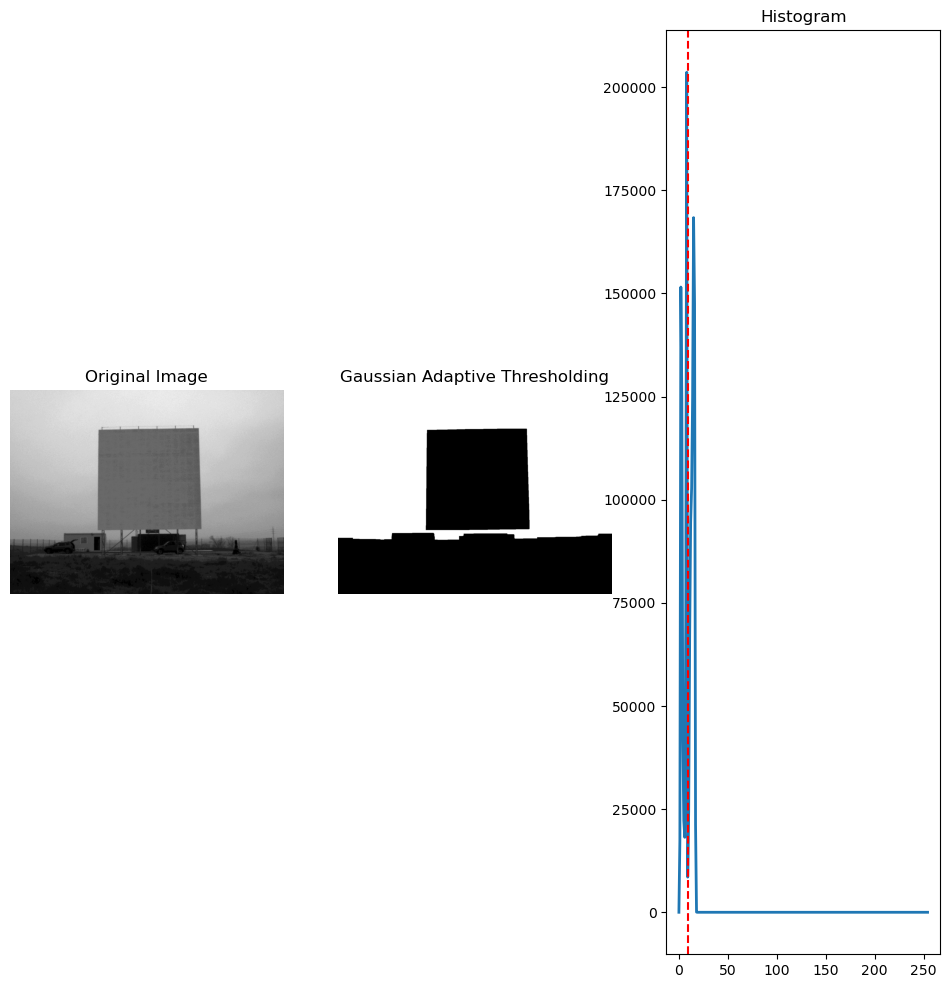

Peak value: 8, Boundary value: 9.6


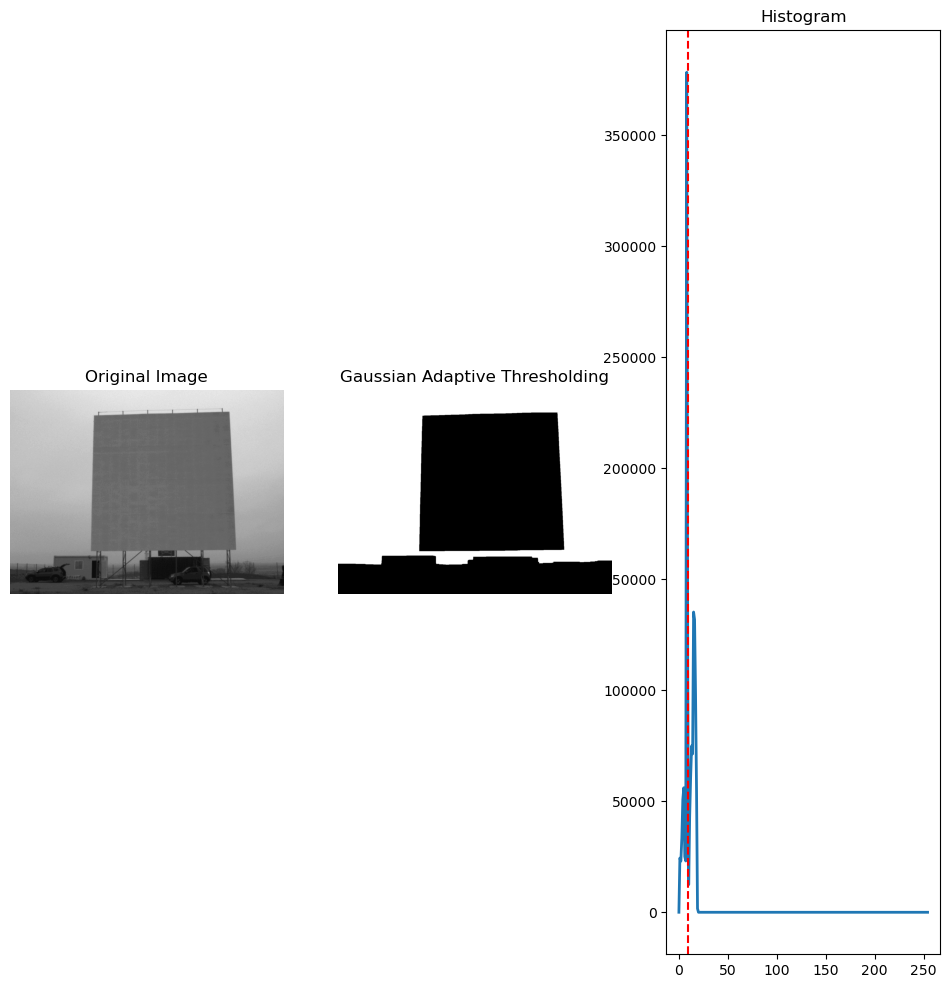

Peak value: 8, Boundary value: 9.6


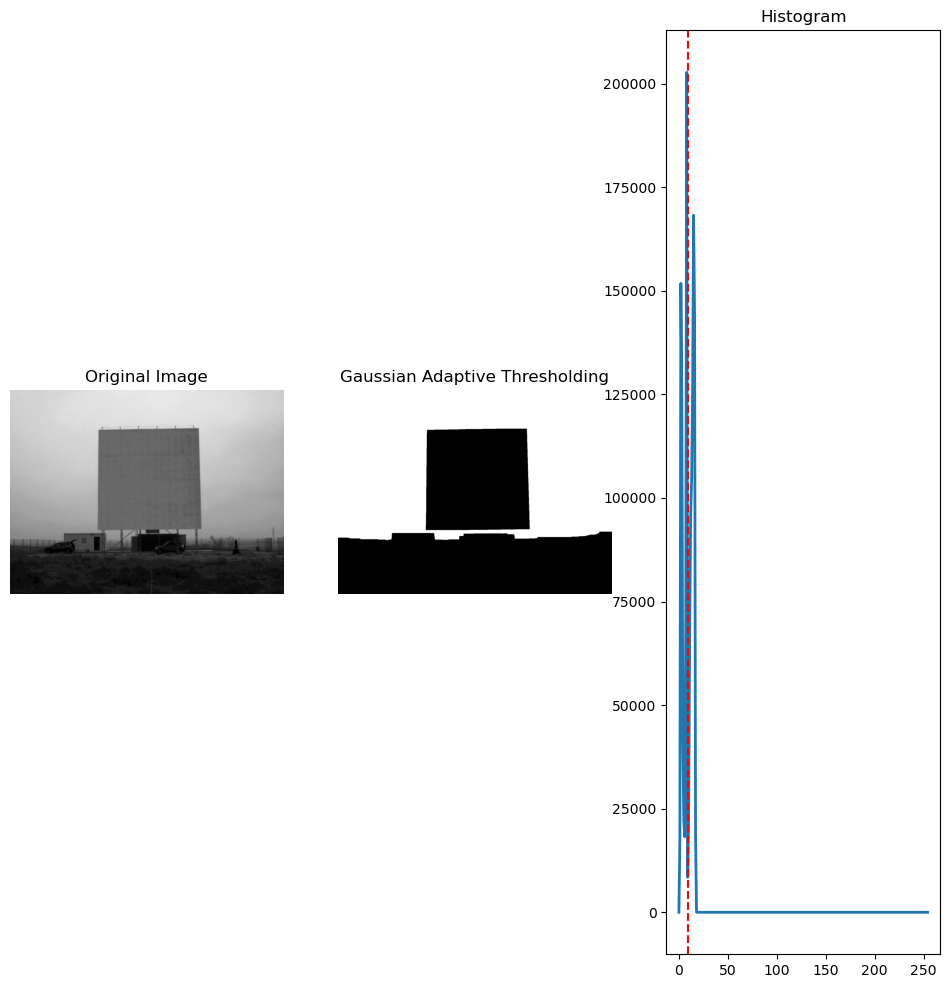

Peak value: 25, Boundary value: 30.0


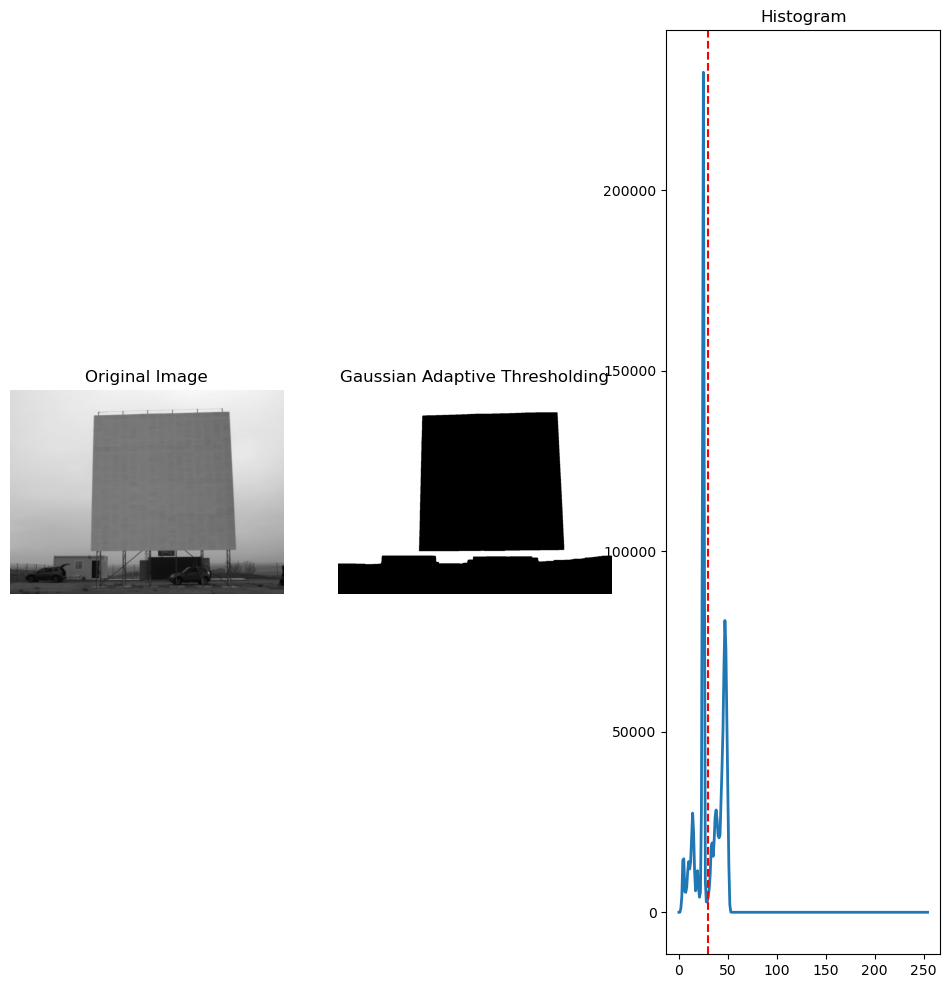

Peak value: 8, Boundary value: 9.6


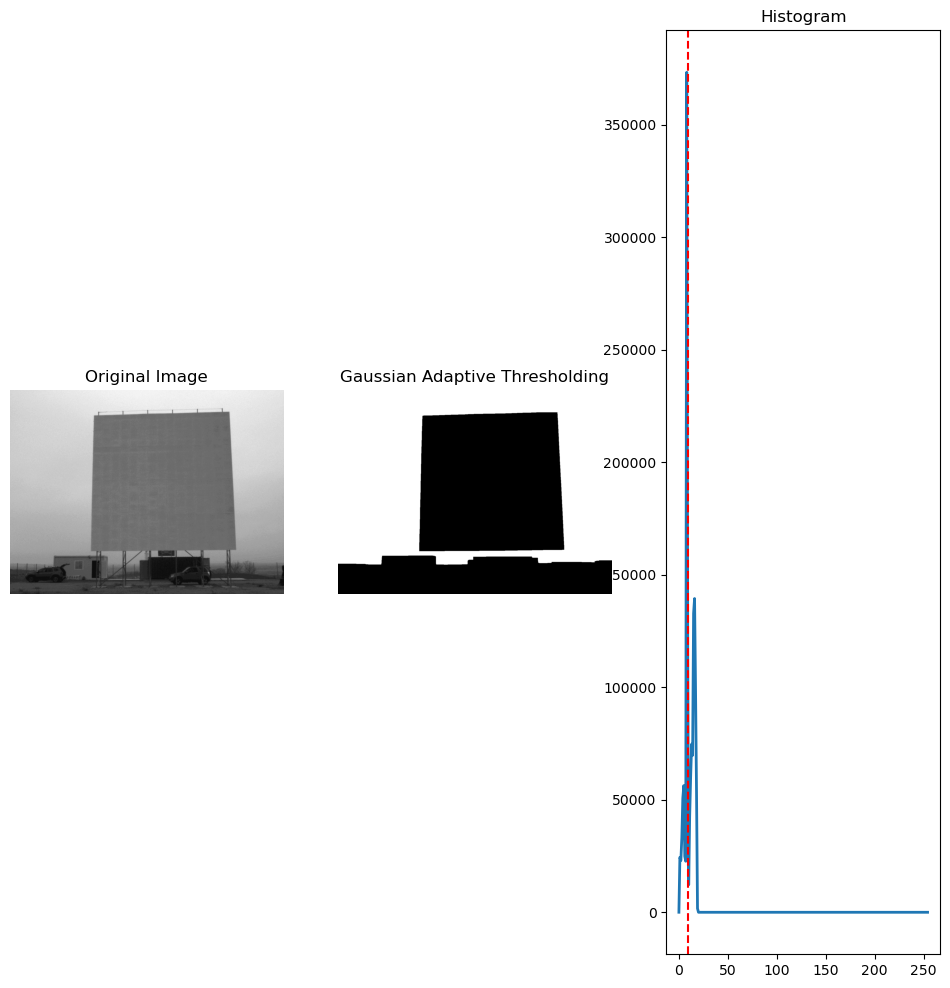

Peak value: 8, Boundary value: 9.6


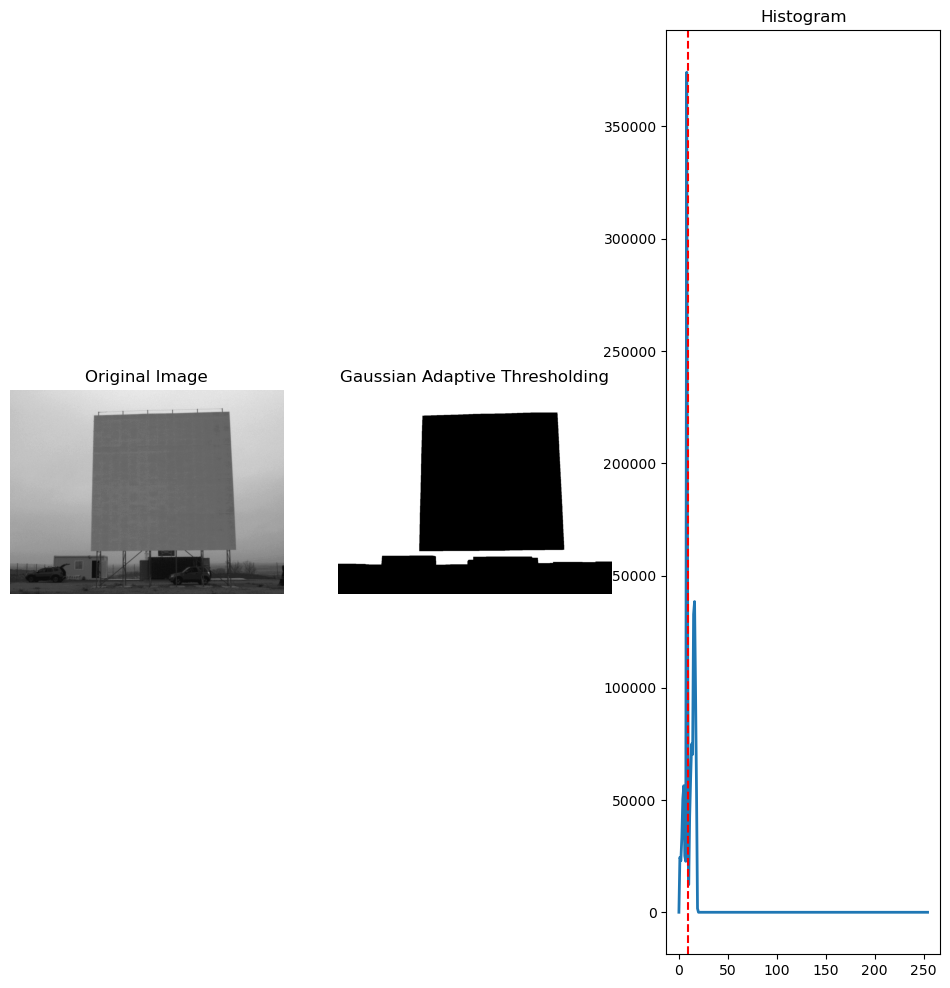

Peak value: 8, Boundary value: 9.6


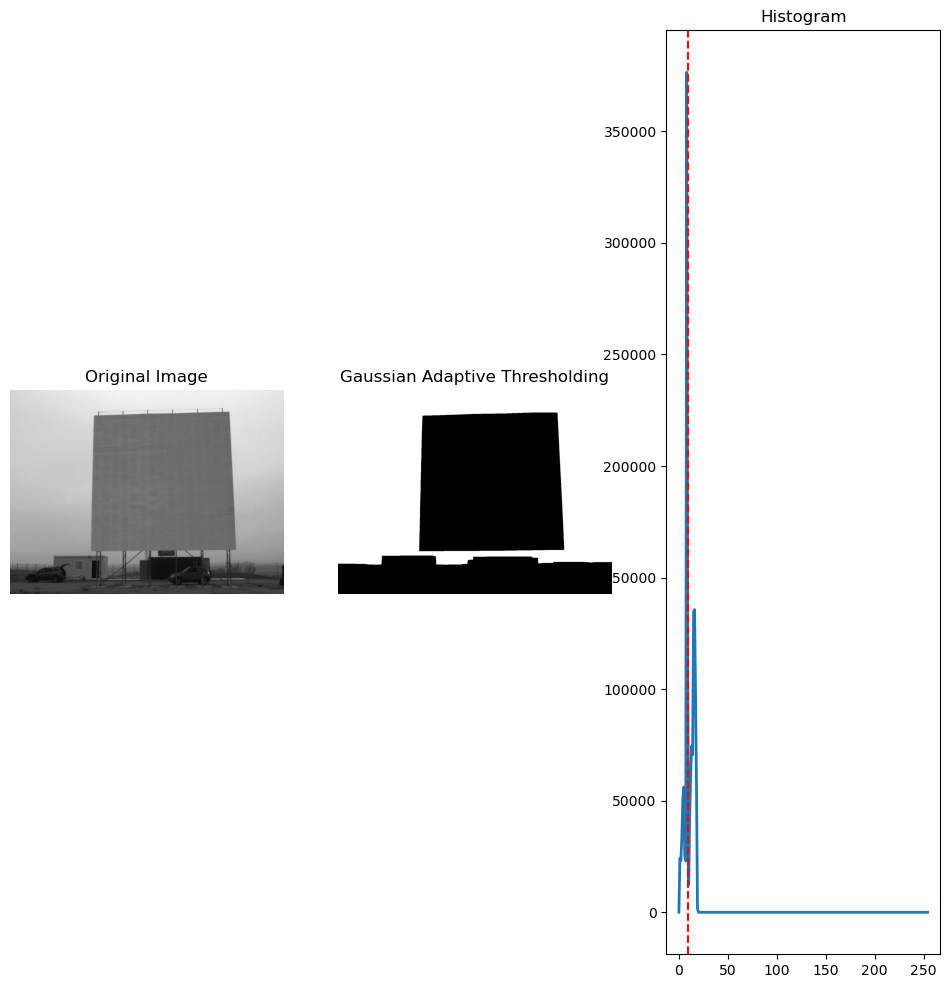

Peak value: 25, Boundary value: 30.0


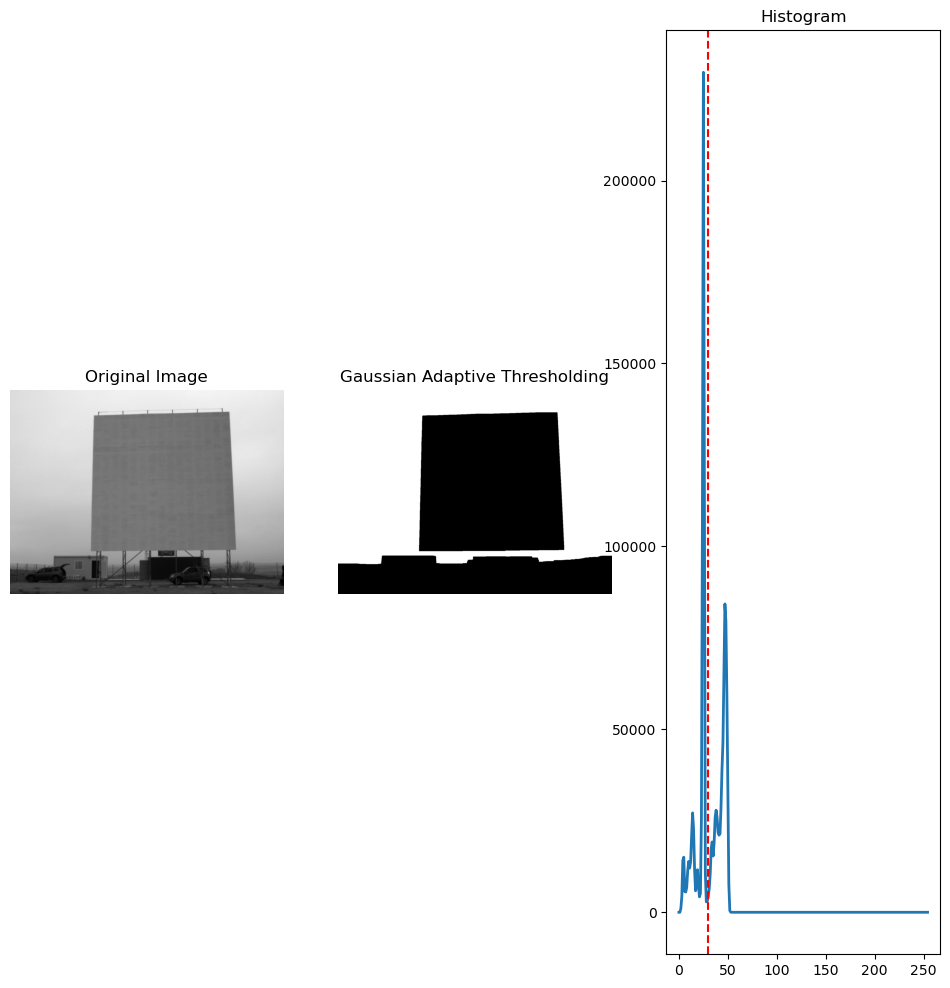

Peak value: 29, Boundary value: 34.8


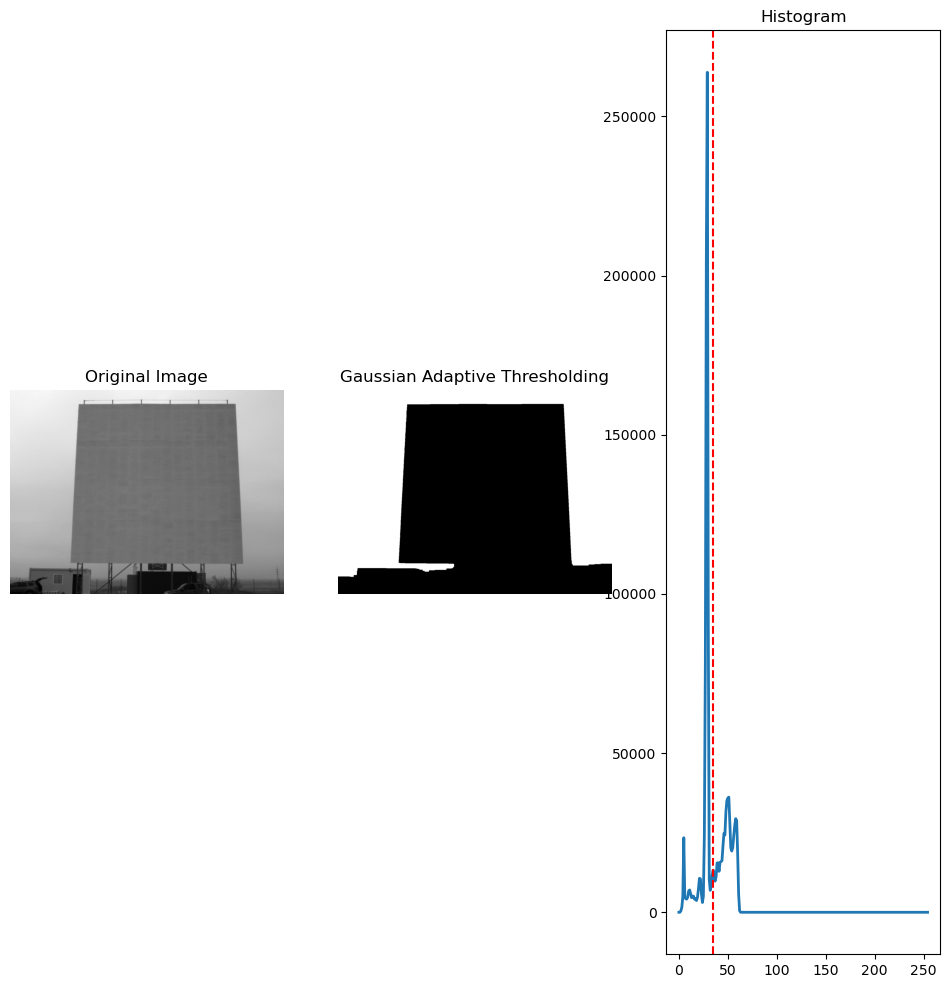

Peak value: 29, Boundary value: 34.8


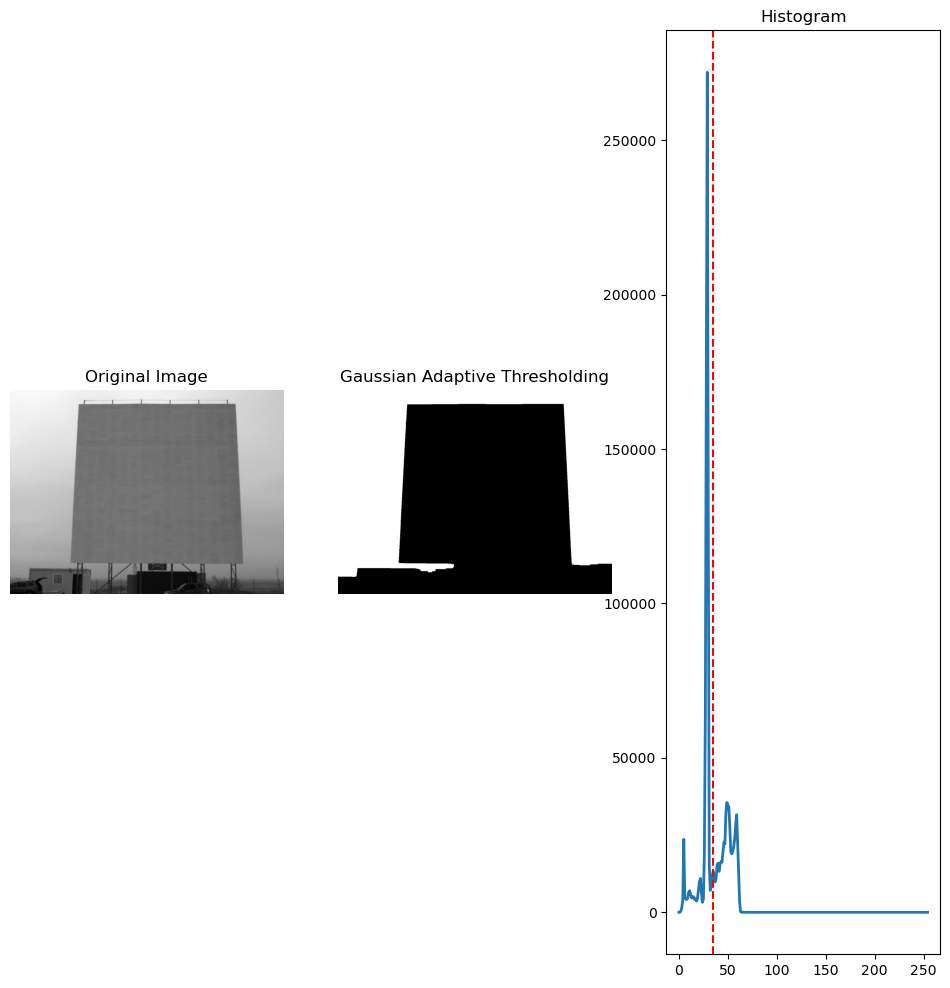

Peak value: 63, Boundary value: 75.6


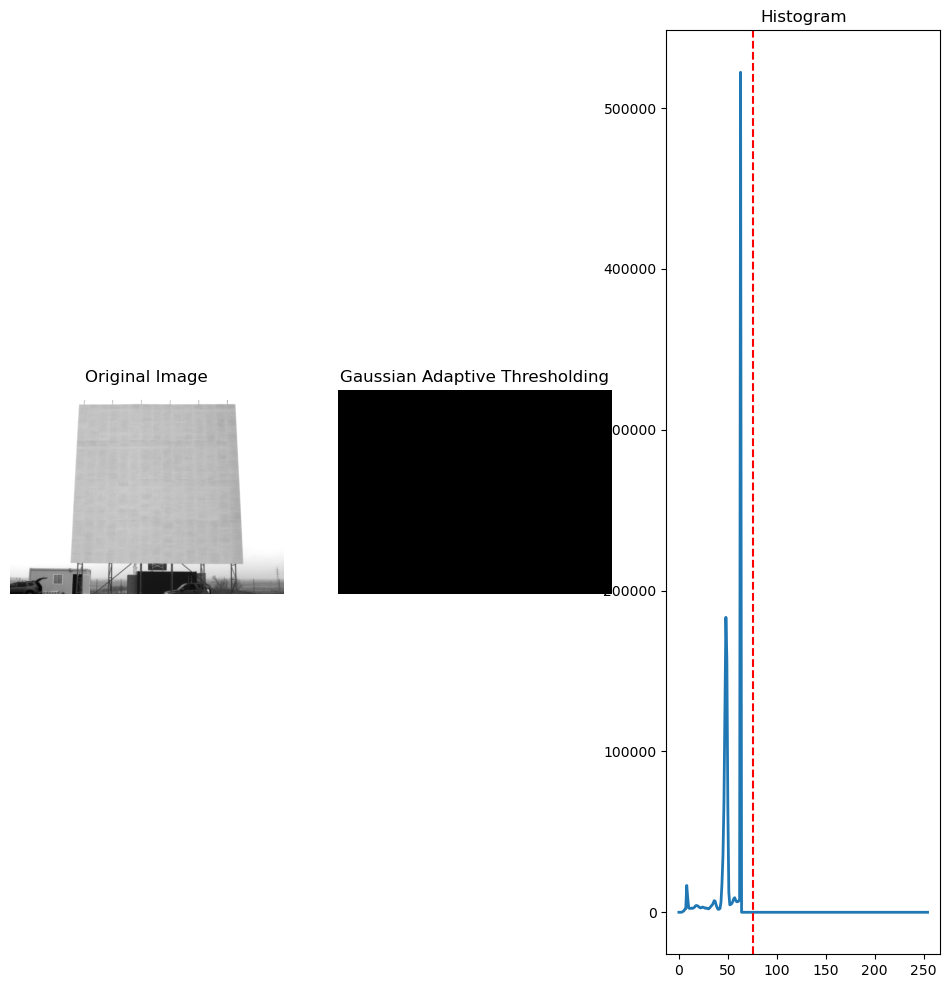

Peak value: 63, Boundary value: 75.6


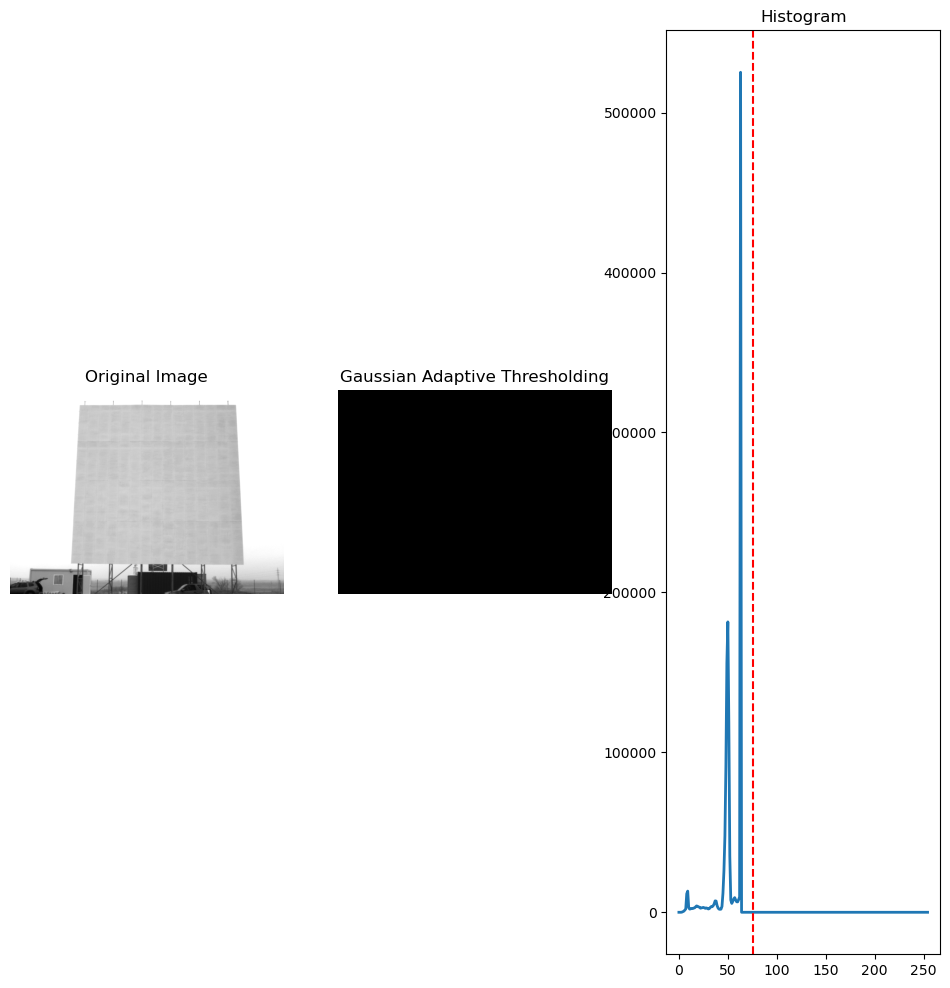

Peak value: 23, Boundary value: 27.599999999999998


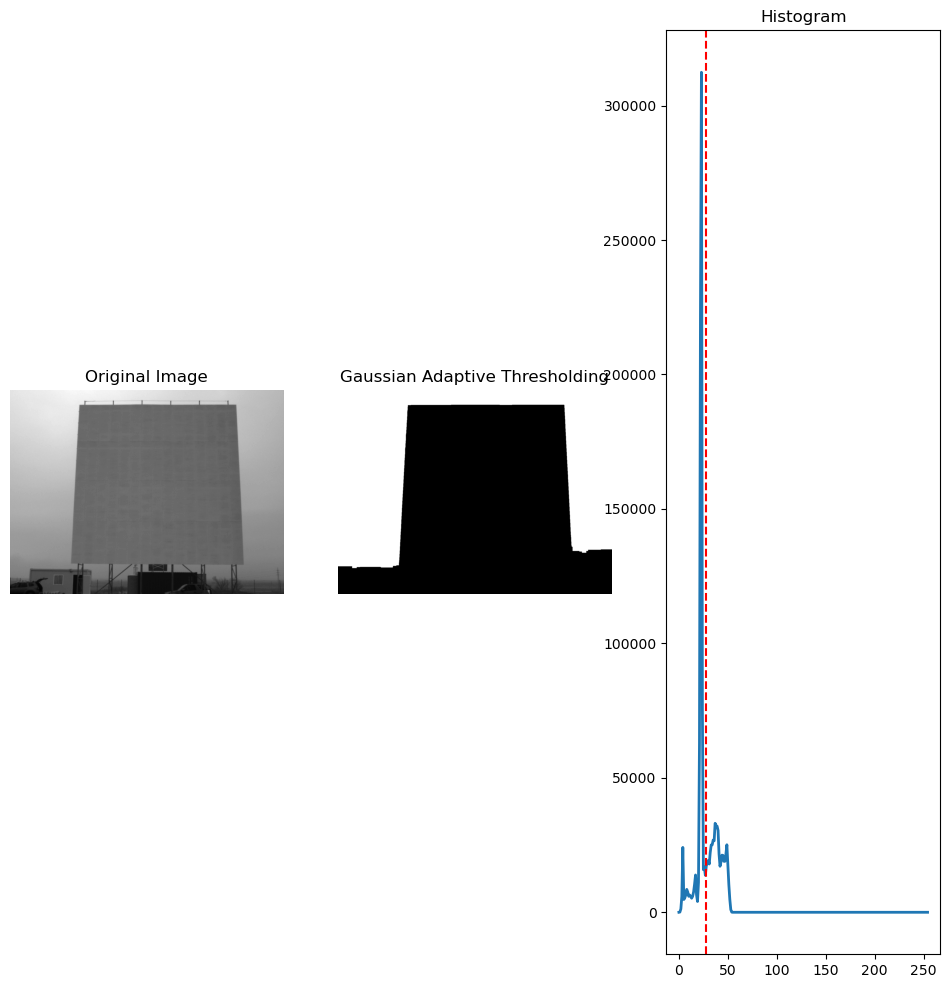

Peak value: 4, Boundary value: 4.8


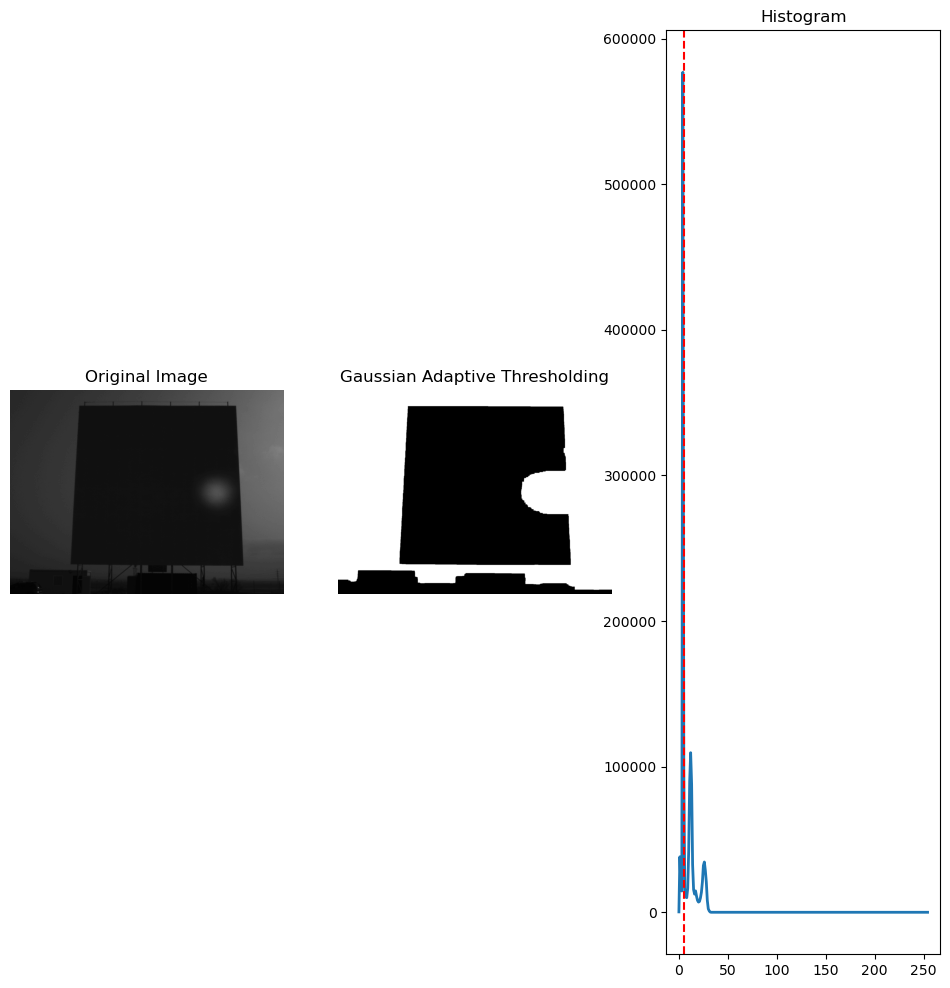

Peak value: 23, Boundary value: 27.599999999999998


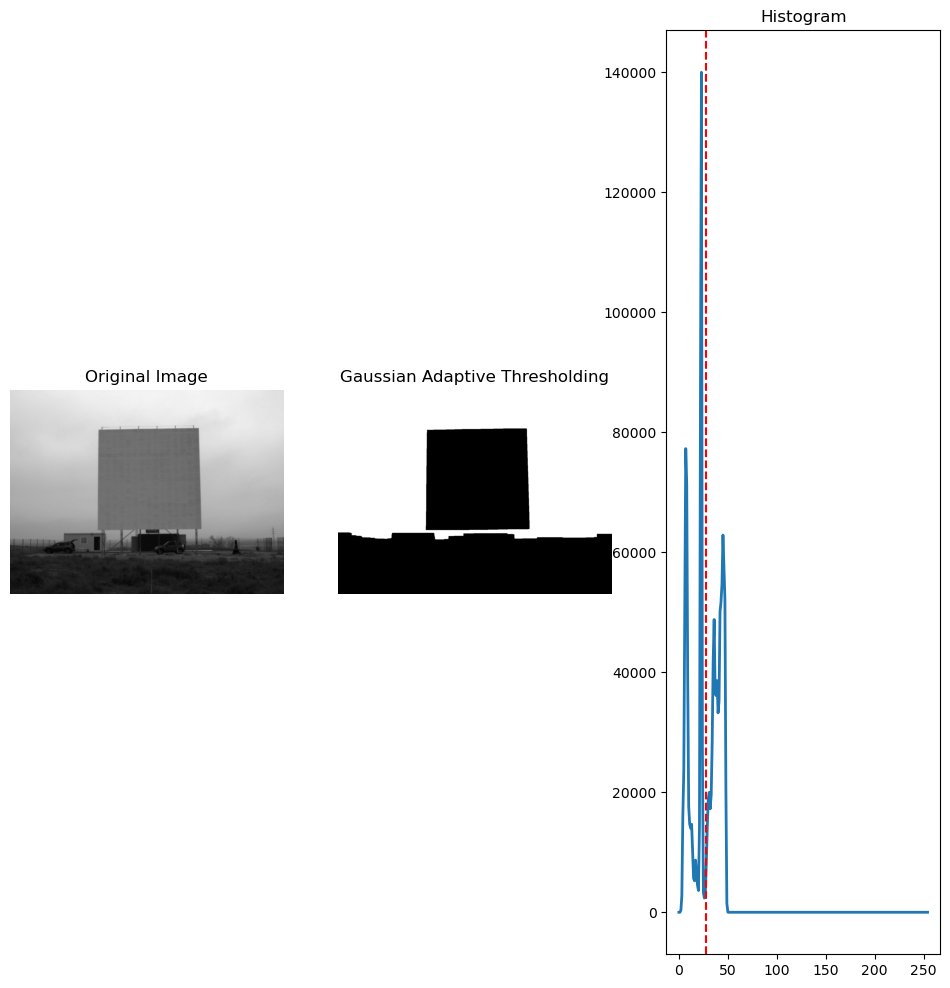

Peak value: 23, Boundary value: 27.599999999999998


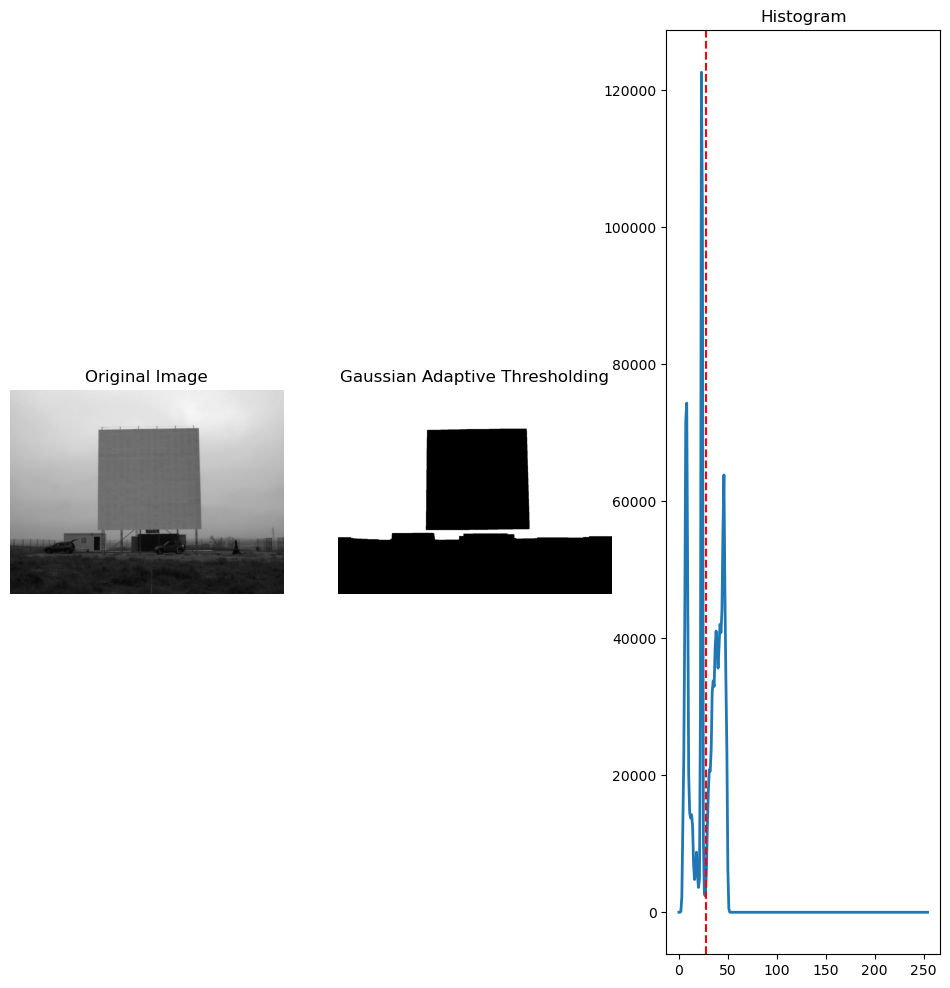

Peak value: 16, Boundary value: 19.2


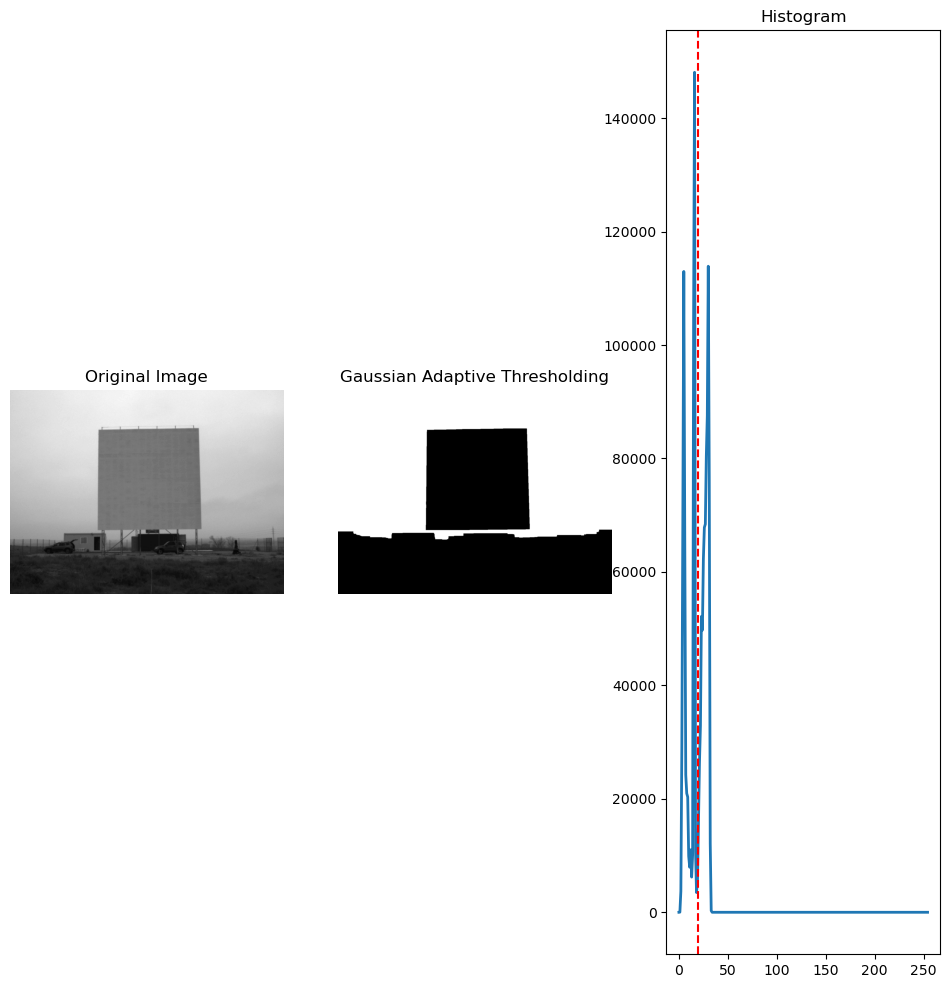

Peak value: 8, Boundary value: 9.6


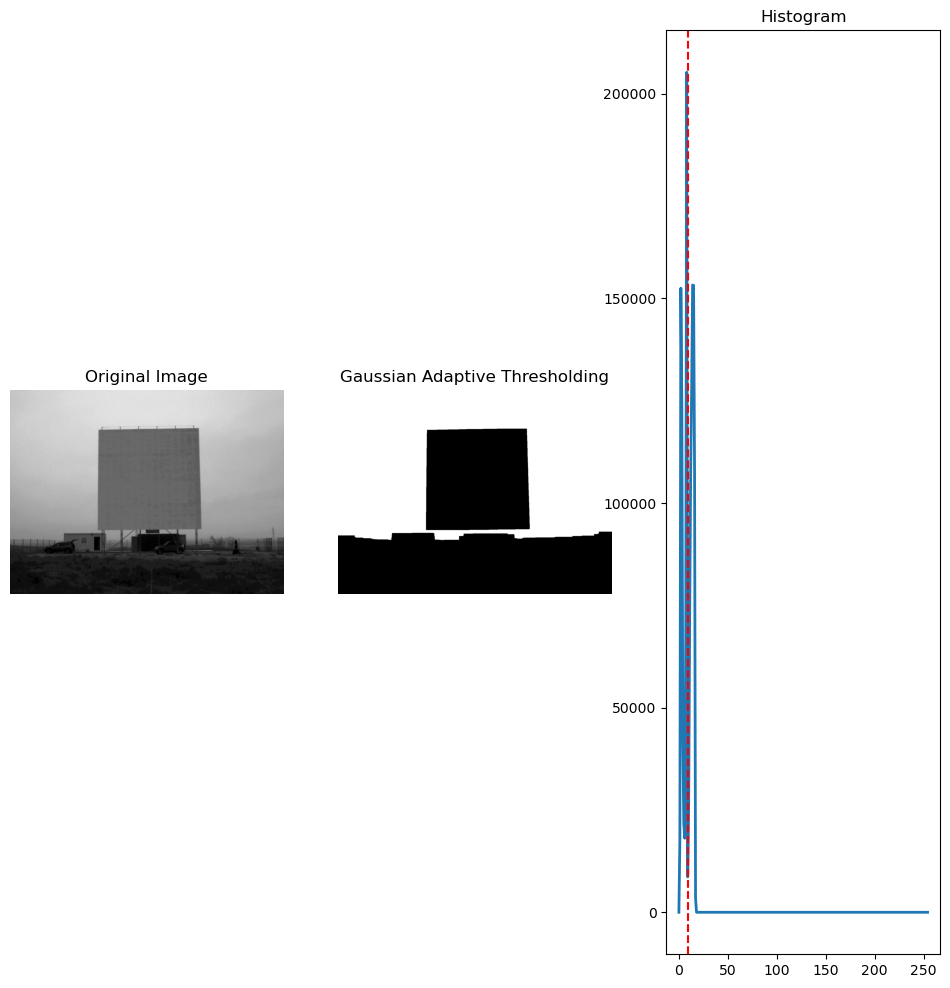

Peak value: 16, Boundary value: 19.2


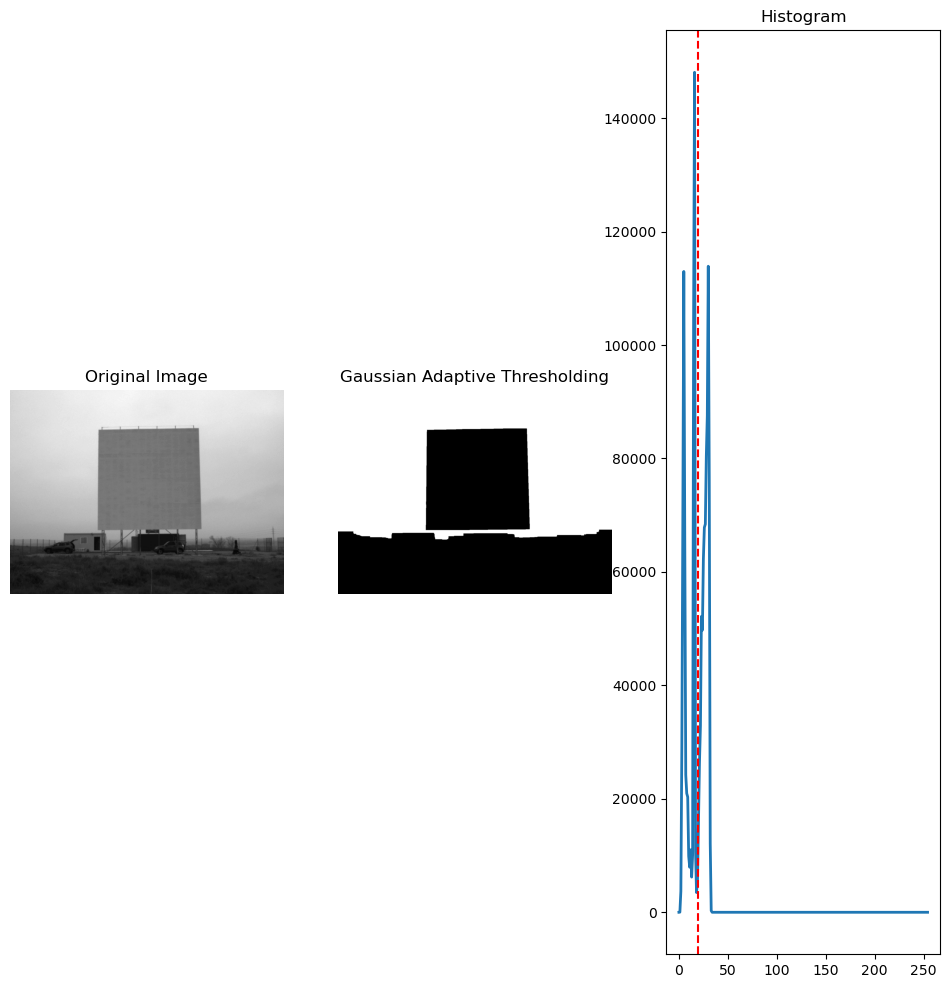

Peak value: 8, Boundary value: 9.6


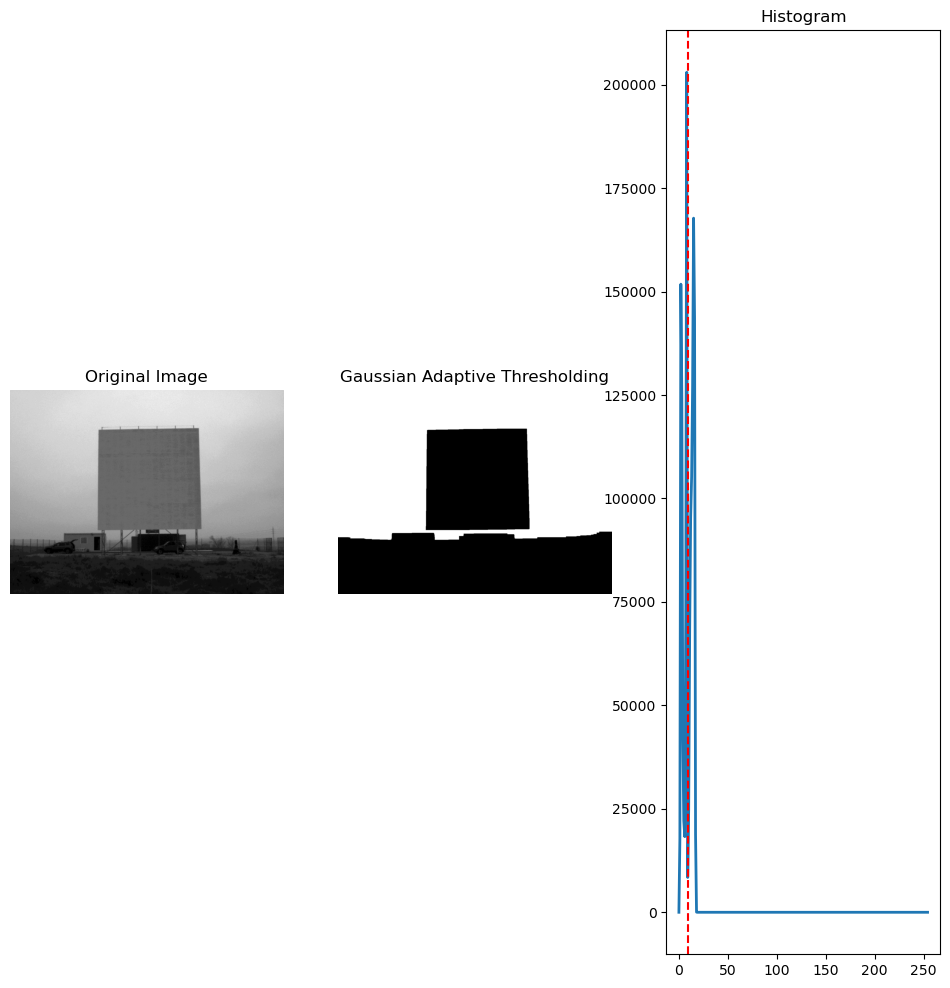

Peak value: 16, Boundary value: 19.2


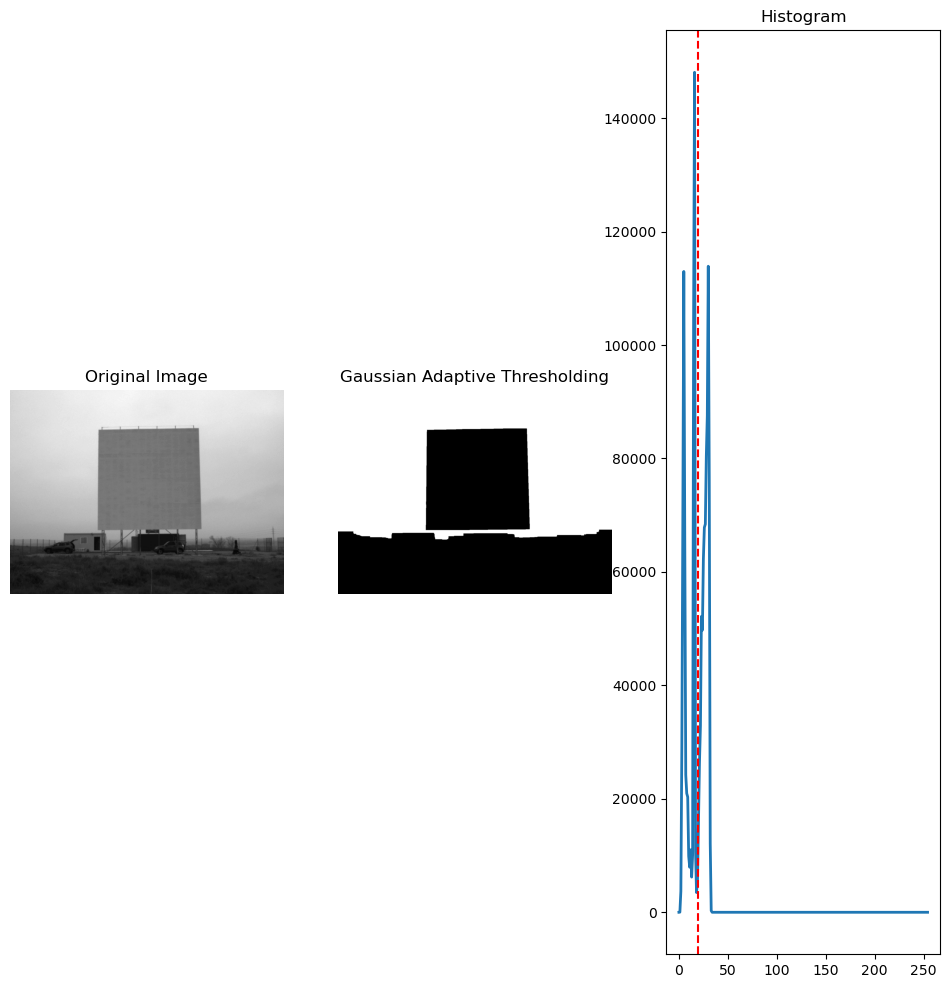

In [3]:
# compare which method can give best results

# data_date_folder = np.random.choice(list(data_name_dict.keys()))    # This gives the data folder
# data_files = data_name_dict[data_date_folder]   # This gives a list of image files in the folder
# data_file = np.random.choice(data_files)

# data_date_folder = r'C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023'
data_date_folder = r'C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\04_03_2021\images\Images_1'
# data_files = data_name_dict[data_date_folder]
data_files = glob(os.path.join(data_date_folder, data_format))

for data_file in data_files:

    _img = cv2.imread(data_file, cv2.IMREAD_GRAYSCALE)
    _img_orig = _img.copy()
    # histogram equalization
    # _img = cv2.equalizeHist(_img)

    # plot histogram of the image
    bin_width = 1
    # get counts of each pixel value
    hist, bins = np.histogram(_img.ravel(), bins=np.arange(0, 256, bin_width))
    # only keep the first 200 values, over exposure is likely going to cause bad segmentation
    hist_crop = hist[:200]
    # find peak
    peak = np.argmax(hist_crop)

    boundary_value = peak *1.2
    print(f"Peak value: {peak}, Boundary value: {boundary_value}")

# histogram equalization
# _img = cv2.equalizeHist(_img)

# Gaussian adaptive thresholding

    _img_gaussian_adaptive = cv2.adaptiveThreshold(_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
    _img_manual_threshold = cv2.threshold(_img, boundary_value, 255, cv2.THRESH_BINARY)[1]
    # morphological closing
    kernel = np.ones((15, 15), np.uint8)
    _img_manual_threshold = cv2.morphologyEx(_img_manual_threshold, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((15, 100), np.uint8)
    _img_manual_threshold = cv2.morphologyEx(_img_manual_threshold, cv2.MORPH_CLOSE, kernel)

    # Otsu thresholding
    _, _img_otsu = cv2.threshold(_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Plot
    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(_img_orig, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(_img_manual_threshold, cmap='gray')
    plt.title("Gaussian Adaptive Thresholding")
    plt.axis('off')

    plt.subplot(133)
    # plot the histogram
    plt.plot(bins[:-1], hist, lw=2)
    plt.axvline(x=boundary_value, color='r', linestyle='--')
    plt.title("Histogram")



    plt.show()



Line: angle=-1.3854407878644033, dist=-7.0
Coordinates: (x0, y0)=(0, 7.121994145064182), (x1, y1)=(1376, 265.1328036494492)
Line: angle=1.3257746370995283, dist=301.0
Coordinates: (x0, y0)=(0, 310.2670360463946), (x1, y1)=(1376, -33.795869473449486)
Line: angle=1.372953559807717, dist=277.0
Coordinates: (x0, y0)=(0, 282.51097748757894), (x1, y1)=(1376, 6.670948898080656)
Line: angle=1.3981156519187512, dist=256.0
Coordinates: (x0, y0)=(0, 259.86478618450695), (x1, y1)=(1376, 19.865944210335478)
Line: angle=1.3603725137522003, dist=288.0
Coordinates: (x0, y0)=(0, 294.49584839976797), (x1, y1)=(1376, 0.6021299776010305)
Line: angle=-1.4168934030031959, dist=-16.0
Coordinates: (x0, y0)=(0, 16.191377173814896), (x1, y1)=(1376, 229.64980082557238)
Line: angle=-1.464072325711385, dist=-8.0
Coordinates: (x0, y0)=(0, 8.04577727643399), (x1, y1)=(1376, 155.45810428792223)
Line: angle=1.4295682670575438, dist=248.0
Coordinates: (x0, y0)=(0, 250.49394722483805), (x1, y1)=(1376, 54.86175243513192)

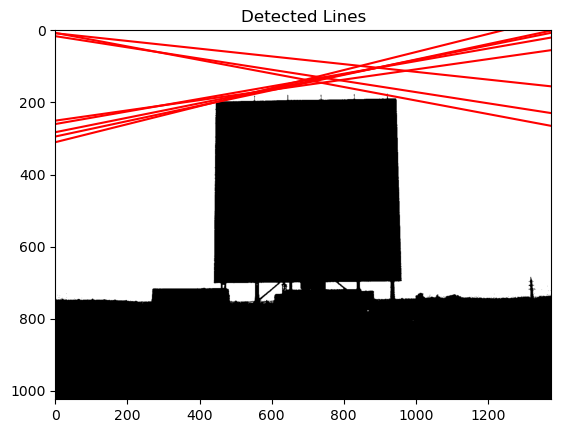

In [4]:
# hough transform
mintestangle = -88.03
maxtestangle = 92
tested_angles = np.linspace((mintestangle*np.pi)/180, (maxtestangle*np.pi)/180, 1000) 
#tested_angles = np.linspace((-np.pi)/2, (np.pi)/2, 100)
h, theta, d = hough_line(_img_otsu, tested_angles)


hpeaks, angles, dists = hough_line_peaks(h,theta,d, min_distance=150, min_angle=2, threshold=150, num_peaks=8)

# Calculate X and Y coordinates
for angle, dist in zip(angles, dists):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - _img_otsu.shape[1] * np.cos(angle)) / np.sin(angle)
    x0, x1 = 0, _img_otsu.shape[1]
    print(f"Line: angle={angle}, dist={dist}")
    print(f"Coordinates: (x0, y0)=({x0}, {y0}), (x1, y1)=({x1}, {y1})")

    # Optionally, plot the lines
    plt.plot((x0, x1), (y0, y1), '-r')

# Plot the image and detected lines
plt.imshow(_img_otsu, cmap='gray')
plt.title('Detected Lines')
plt.show()

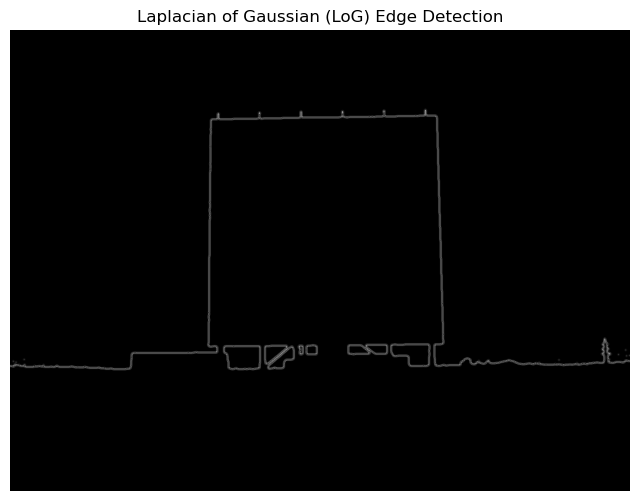

In [5]:
# do a morphological opening
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(_img_otsu, cv2.MORPH_OPEN, kernel)

blurred_image = cv2.GaussianBlur(opening, (5, 5), 0)

# Apply the Laplacian operator on the blurred image
laplacian = cv2.Laplacian(blurred_image, cv2.CV_64F)

# Convert the Laplacian result to uint8 (normal image format) for visualization
laplacian = np.uint8(np.absolute(laplacian))

# Display the Laplacian of Gaussian result using matplotlib
plt.figure(figsize=(8, 8))  # Optionally, set the figure size
plt.imshow(laplacian, cmap='gray')  # Display in grayscale
plt.title('Laplacian of Gaussian (LoG) Edge Detection')
plt.axis('off')  # Hide axes
plt.show()
